<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/GSE109037_GSM3302524_HNTYNBGX3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSE109037:GSM3302524

In [1]:
# define the values for the analysis

# accession id for the data
id = "GSE109037"

# If only bam available files, set bam = True, Fill link and filename
bam = True
if bam:
  # Assign link to python variable
  link_to_bam = "https://sra-pub-src-1.s3.amazonaws.com/SRR7553900/AdultHuman_Spermatocytes_17_11_possorted_genome_bam.bam.1"
  
  # Assigns the link to the bash variable BAM_LINK. To be used by wget
  %env BAM_LINK=$link_to_bam

  # Assign filename to python variable. Used to convert to fastq and remove bam file to fastq after conversion

  bam_filename="AdultHuman_Spermatocytes_17_11_possorted_genome_bam.bam.1"

if not bam:
  fastqs = ["",
            "",
            ]


env: BAM_LINK=https://sra-pub-src-1.s3.amazonaws.com/SRR7553900/AdultHuman_Spermatocytes_17_11_possorted_genome_bam.bam.1


In [2]:
no_samples = 1

database_id = [id] * no_samples

tissue = ["testis"] * no_samples

cell_type = ["spermatocytes"] * no_samples

sample_id = ["GSM3302524"] * no_samples

condition = ["17-11"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Muus et al 2020"] * no_samples

figure = ["Fig 1 a,b  ED Fig 1 a,b,c,d  ED Fig 2 a,b,c,d,e"] * no_samples


# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]

# Imports and installs

In [3]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 35.4MB 1.2MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 122kB 52.9MB/s 
     |████████████████████████████████| 112kB 53.0MB/s 
     |████████████████████████████████| 7.7MB 2.7MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


# Downloads: (bam (if bam) and index

In [4]:
if bam:

  # Install bamtofastq from 10x website (only bam files available)
  !wget http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
  !chmod +x bamtofastq-1.2.0
  # Download the bam file
  !wget -- continue ${BAM_LINK}




--2020-09-26 23:30:19--  http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/misc/bamtofastq-1.2.0 [following]
--2020-09-26 23:30:19--  https://cf.10xgenomics.com/misc/bamtofastq-1.2.0
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288280 (13M) [binary/octet-stream]
Saving to: ‘bamtofastq-1.2.0’

bamtofastq-1.2.0    100%[===================>]  12.67M  --.-KB/s    in 0.1s    

2020-09-26 23:30:20 (112 MB/s) - ‘bamtofastq-1.2.0’ saved [13288280/13288280]

--2020-09-26 23:30:20--  http://continue/
Resolving continue (continue)... failed: Name or service not known.
wget: unable to resolve host address ‘continue’
--2

In [5]:
if bam:
  # Convert to fastq
  !./bamtofastq-1.2.0 --reads-per-fastq=500000000 $bam_filename ./fastqs\

  # Remove original bam file to save space
  !rm $bam_filename


bamtofastq v1.2.0
Args { arg_bam: "AdultHuman_Spermatocytes_17_11_possorted_genome_bam.bam.1", arg_output_path: "./fastqs", flag_nthreads: 4, flag_locus: None, flag_bx_list: None, flag_reads_per_fastq: 500000000, flag_gemcode: false, flag_lr20: false, flag_cr11: false }
Writing finished.  Observed 321147150 read pairs. Wrote 321147150 read pairs


In [6]:
# Store fastq names on a list

if bam:
  # cd into fastqs folder
  %cd /content/fastqs

  #store the name of the folder generated by bamtofastq
  _filename = os.listdir()[0]

  # MODIFIED:
  %cd Human_SS082317_Sct1_MissingLibrary_1_HNTYNBGX3

  # store fastq names in a list
  fastqs = os.listdir()


  # Remove I1 and R3 reads not relevant for our analysis

  print ("\n\nThis is the complete list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)

  for elem in fastqs:
    if re.search("_R3_", elem) or re.search("_I1_", elem):
      fastqs.remove(elem)

  print ("\n\nThis is the filtered list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)


/content/fastqs
/content/fastqs/Human_SS082317_Sct1_MissingLibrary_1_HNTYNBGX3


This is the complete list of fastqs:
 -----------
bamtofastq_S1_L004_R2_001.fastq.gz
bamtofastq_S1_L004_R1_001.fastq.gz
bamtofastq_S1_L003_I1_001.fastq.gz
bamtofastq_S1_L003_R2_001.fastq.gz
bamtofastq_S1_L004_I1_001.fastq.gz
bamtofastq_S1_L001_R1_001.fastq.gz
bamtofastq_S1_L003_R1_001.fastq.gz
bamtofastq_S1_L001_I1_001.fastq.gz
bamtofastq_S1_L002_I1_001.fastq.gz
bamtofastq_S1_L002_R1_001.fastq.gz
bamtofastq_S1_L001_R2_001.fastq.gz
bamtofastq_S1_L002_R2_001.fastq.gz


This is the filtered list of fastqs:
 -----------
bamtofastq_S1_L004_R2_001.fastq.gz
bamtofastq_S1_L004_R1_001.fastq.gz
bamtofastq_S1_L003_R2_001.fastq.gz
bamtofastq_S1_L001_R1_001.fastq.gz
bamtofastq_S1_L003_R1_001.fastq.gz
bamtofastq_S1_L002_I1_001.fastq.gz
bamtofastq_S1_L002_R1_001.fastq.gz
bamtofastq_S1_L001_R2_001.fastq.gz
bamtofastq_S1_L002_R2_001.fastq.gz


In [7]:
if bam:
  # sort fastqs alphabetically to get R1 and R2 in order
  fastqs = sorted(fastqs)

In [8]:
if bam:
  # Download the corresponding Kallisto index to folder containing fastqs
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam:
  %cd /content

  # Download the corresponding Kallisto index to content folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-09-27 00:55:26,163]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-09-27 00:57:54,706]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [9]:
print(fastqs)

['bamtofastq_S1_L001_R1_001.fastq.gz', 'bamtofastq_S1_L001_R2_001.fastq.gz', 'bamtofastq_S1_L002_I1_001.fastq.gz', 'bamtofastq_S1_L002_R1_001.fastq.gz', 'bamtofastq_S1_L002_R2_001.fastq.gz', 'bamtofastq_S1_L003_R1_001.fastq.gz', 'bamtofastq_S1_L003_R2_001.fastq.gz', 'bamtofastq_S1_L004_R1_001.fastq.gz', 'bamtofastq_S1_L004_R2_001.fastq.gz']


Make sure I1 files are erased

# Process fastq files (modify kb command according to fastqs list)


In [10]:
!pwd

/content/fastqs/Human_SS082317_Sct1_MissingLibrary_1_HNTYNBGX3


In [11]:
fastqs

['bamtofastq_S1_L001_R1_001.fastq.gz',
 'bamtofastq_S1_L001_R2_001.fastq.gz',
 'bamtofastq_S1_L002_I1_001.fastq.gz',
 'bamtofastq_S1_L002_R1_001.fastq.gz',
 'bamtofastq_S1_L002_R2_001.fastq.gz',
 'bamtofastq_S1_L003_R1_001.fastq.gz',
 'bamtofastq_S1_L003_R2_001.fastq.gz',
 'bamtofastq_S1_L004_R1_001.fastq.gz',
 'bamtofastq_S1_L004_R2_001.fastq.gz']

In [12]:
# Specify the sample number you are analyzing
number_of_samples = 1

# Initializa counter for fastq files
j = 0
# Loop over samples for analysis
for i in range(number_of_samples):

  # 0-based Index for fastqs:
  # Write the kb count command as a string
  cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
  --filter bustools -t 2 --overwrite " +\
  fastqs[j] + " " + fastqs[j+1] + " " + fastqs[j+3] + " " + fastqs[j+4] + " " + fastqs[j+5] + " " + fastqs[j+6] + " " + fastqs[j+7] + " " + fastqs[j+8]
  # Execute it
  !$cmd
  # Update j to get the two next fastqs
  j = j + 2




[2020-09-27 00:58:35,308]    INFO Generating BUS file from
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L001_R1_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L001_R2_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L002_R1_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L002_R2_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L003_R1_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L003_R2_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L004_R1_001.fastq.gz
[2020-09-27 00:58:35,308]    INFO         bamtofastq_S1_L004_R2_001.fastq.gz
[2020-09-27 01:20:07,210]    INFO Sorting BUS file outputGSM3302524/output.bus to tmp/output.s.bus
[2020-09-27 01:22:50,148]    INFO Whitelist not provided
[2020-09-27 01:22:50,149]    INFO Copying pre-packaged 10XV2 whitelist to outputGSM3302524
[2020-09-27 01:22:53,298]    INFO Inspecting BUS file tmp/output.s.bus
[2020-0

# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrix (check dimensions)

In [13]:
# Define dict to store data
results = {}


In [14]:
# load the unfiltered matrix
for i in range(number_of_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
  t2g.index = t2g.gene_id
  t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix GSM3302524 contains 438379 cells by 60623 genes


## Assign filters for each matrix individually

In [15]:
# Modify this manually to change sample after having assigned the "expected_num_cells" and "mito_criteria" parameters
samp_n = 0


# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

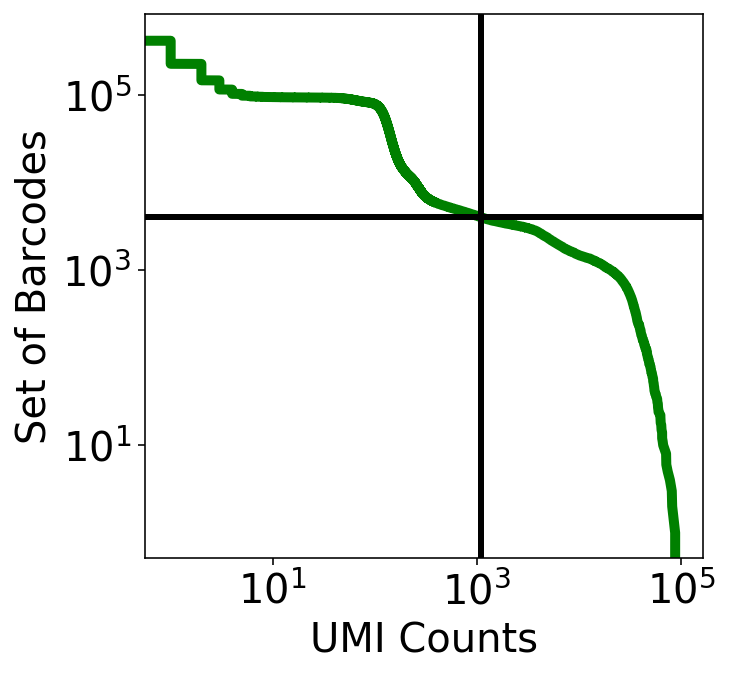

Cells were filtered down to 4000 with at least 1098.0 UMIs


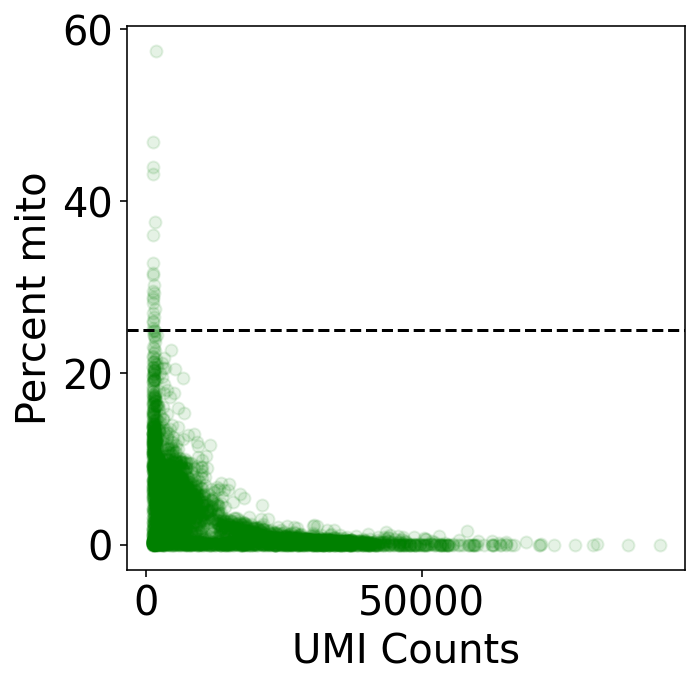

We select 25 % as the mitochondrial content threshold


In [22]:

expected_num_cells = 4000#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[i]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 25#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[i]].obs["cell_counts"][results[sample_id[i]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[i]].obs["percent_mito"][results[sample_id[i]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [23]:
for i in range(number_of_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 438,379 cells x 60,623 genes
    New shape: 3,978 cells x 37,896 genes


# Anotate and write the Anndata object

In [24]:
for i in range(number_of_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id[samp_n]

  results["data_" + sample_id[i]].uns["tissue"] = tissue[samp_n]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[samp_n]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[samp_n]

  results["data_" + sample_id[i]].uns["condition"] = condition[samp_n]

  results["data_" + sample_id[i]].uns["species"] = species[samp_n]

  results["data_" + sample_id[i]].uns["technology"] = technology[samp_n]

  results["data_" + sample_id[i]].uns["paper"] = paper[samp_n]

  results["data_" + sample_id[i]].uns["figure"] = figure[samp_n]

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [25]:
%cd /content

for i in range(number_of_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

/content


... storing 'gene_name' as categorical
